In [1]:
import torch
import torch.nn as nn  # neural network modules
import torch.nn.functional as F  # activation functions
import torch.optim as optim  # optimizer
from torch.autograd import Variable # add gradients to tensors
from torch.nn import Parameter # model parameter functionality 

import pandas as pd
import numpy as np
import csv
import itertools

from bert_embedding import BertEmbedding

In [2]:
# Target labels
label_encodings3 = {
    'pants-fire': 0, 
    'false':      0, 
    'barely-true':1, 
    'half-true':  1, 
    'mostly-true':2,
    'true':       2
}
label_encodings6 = {
    'pants-fire': 0, 
    'false':      1, 
    'barely-true':2, 
    'half-true':  3, 
    'mostly-true':4,
    'true':       5
}

### Glove Model

In [3]:
# Read Glove file
words = pd.read_table("../glove.6B.100d.txt", sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)

# Generate Glove dictionary
glove = {word:words.iloc[idx].values for (word,idx) in zip(words.index,range(words.shape[0]))}

In [4]:
def clean(sentence):
    return sentence.replace('?',' ?').replace('.',' .').lower().split()

def make_weights_matrix(target_vocab, glove_dict):
    """
    Generate the weights_matrix, which is the matrix of word embeddings that we
    pass into Pytorch. It contains len(target_vocab) rows for each of the words,
    each represented by a length-100 vector – taken from the Glove embedding
    """
    weights_matrix = np.zeros((len(target_vocab)+1,100))

    # Add in vocab
    error_count = 0
    word_to_idx = {}
    for i, word in enumerate(target_vocab):
        word_to_idx[word] = i
        try: 
            weights_matrix[i] = glove_dict[word]
        except KeyError:
            weights_matrix[i] = np.random.normal(scale=0.6, size=(100,))
            error_count += 1

    # Add in "empty" token
    word_to_idx[""] = len(target_vocab)

    print(f"We found {error_count} out of {len(target_vocab)} words not in the Glove model")
    
    return weights_matrix, word_to_idx

In [5]:
def create_emb_layer(weights_matrix, 
                     non_trainable=False):
    weights_matrix = torch.Tensor(weights_matrix)
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

### FakeBERT

In [6]:
class FakeBERT(nn.Module):
    def __init__(self, weights_matrix, num_classes):
        super(FakeBERT, self).__init__()
        
        # Layer 0: Embedding Layer
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)

        # Layer 1: Conv1D + Maxpool
        self.conv_1 = nn.Conv1d(in_channels=100, out_channels=128, kernel_size=3, stride=1)
        self.sigm_1 = nn.ReLU()
        self.pool_1 = nn.MaxPool1d(kernel_size=5, stride=5)
        
        # Layer 2: Conv1D + Maxpool
        self.conv_2 = nn.Conv1d(in_channels=100, out_channels=128, kernel_size=4, stride=1)
        self.sigm_2 = nn.ReLU()
        self.pool_2 = nn.MaxPool1d(kernel_size=5, stride=5)
        
        # Layer 3: Conv1D + Maxpool
        self.conv_3 = nn.Conv1d(in_channels=100, out_channels=128, kernel_size=5, stride=1)
        self.sigm_3 = nn.ReLU()
        self.pool_3 = nn.MaxPool1d(kernel_size=5, stride=5)
        
        # Layer 4: Conv1D + Maxpool
        self.conv_4 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=5, stride=1)
        self.sigm_4 = nn.ReLU()
        self.pool_4 = nn.MaxPool1d(kernel_size=5, stride=5)
        
        # Layer 5: Conv1D + Maxpool
        self.conv_5 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=5, stride=1)
        self.sigm_5 = nn.ReLU()
        self.pool_5 = nn.MaxPool1d(kernel_size=5, stride=5)
        
        # Layer 6: Fully Connected Layer 
        self.full_6 = nn.Linear(128,32)
        self.sigm_6 = nn.Sigmoid()
        
        # Layer 7: Fully Connected Layer 
        self.full_7 = nn.Linear(32,num_classes)
        self.soft_7 = nn.Softmax()
        
    def forward(self, x):
        # Generate the embeddings with Glove
        emb = self.embedding(x)

        # Generate the 3 1D conv layers
        conv_1 = self.pool_1(self.sigm_1(self.conv_1(emb)))        
        conv_2 = self.pool_2(self.sigm_2(self.conv_2(emb)))        
        conv_3 = self.pool_3(self.sigm_3(self.conv_3(emb)))
        
        # Concatenate the 3 layers
        cat = torch.cat((conv_1,conv_2,conv_3),2)
        
        # Pass the concatenated output through 2 1D conv layers
        conv_4 = self.pool_4(self.sigm_4(self.conv_4(cat)))        
        conv_5 = self.pool_5(self.sigm_5(self.conv_5(conv_4)))  

        # Flatten the output
        flat = conv_5.flatten(start_dim=1)

        # Pass through 2 fully connected layers
        full_6 = self.sigm_6(self.full_6(flat))
        full_7 = self.soft_7(self.full_7(full_6))
        
        return full_7

In [7]:
def get_accuracy(output, targets):

    predicted = [int(y_pred.detach().argmax(-1)) for y_pred in output]
    targets = [int(y) for y in targets]
    correct = sum(a==b for (a,b) in zip(predicted, targets))
    accuracy = 100*correct/len(targets) 

    return accuracy

def train(train_X,
          test_X,
          train_y,
          test_y,
          weights_matrix,
          num_classes = 3,
          num_epochs = 10,
          batch_size = 10,
          learning_rate = 1e-4):
    
    # Instantiate model & optimization 
    model = FakeBERT(weights_matrix, num_classes)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Prepare test data
    test_X = torch.Tensor([i for i in test_X]).to(dtype=torch.long)
    test_y = torch.Tensor(test_y.values).to(dtype=torch.long)
    
    # Collect loss
    loss_func = nn.CrossEntropyLoss()
    loss_train, loss_test = [], []
    
    # Iterate over epochs
    for ep in range(num_epochs):
        
        model.train()
        temp_loss = []

        # Iterate over batches
        for i in range(train_X.shape[0]//batch_size):
            # Reset gradients
            optimizer.zero_grad()
            
            # Declare features and target labels
            X = torch.Tensor([i for i in train_X[i*batch_size:(i+1)*batch_size]]).to(dtype=torch.long)
            y = train_y[i*batch_size:(i+1)*batch_size].values
            y = torch.Tensor(y).to(dtype=torch.long)

            # Get predictions from model
            pred = model(X)

            # Calculate loss
            loss = loss_func(pred, y)
            temp_loss.append(float(loss.detach()))

            # Backpropagate
            loss.backward()

            # Update parameters
            optimizer.step()
        
        # Record train loss
        loss_train.append(sum(temp_loss)/len(temp_loss))
        
        # Evaluate model
        model.eval()
            
        # Evaluate on test data
        test_pred = model(test_X)
        test_accuracy = get_accuracy(test_pred, test_y)
        loss_test.append(float(loss_func(test_pred, test_y).detach()))
        
        # Print accuracy
        print(f"Test accuracy: {test_accuracy} at epoch: {ep}")

    return model, loss_train, loss_test

### Train

In [8]:
# Read in data
df_train = pd.read_csv("Data/liar_dataset/train.csv")
df_test = pd.read_csv("Data/liar_dataset/test.csv")
df_valid = pd.read_csv("Data/liar_dataset/valid.csv")

# Relabel
df_train['target'] = df_train['label'].apply(lambda x: label_encodings6[x])
df_test['target'] = df_test['label'].apply(lambda x: label_encodings6[x])
df_valid['target'] = df_valid['label'].apply(lambda x: label_encodings6[x])

In [9]:
# Cleaning

# Split the text into words
df_train['words'] = df_train['statement'].apply(clean)
df_test['words'] = df_test['statement'].apply(clean)
df_valid['words'] = df_valid['statement'].apply(clean)

# Cap sentences at 100 words, then pad sentences to 100 words using "" token
df_train['words'] = df_train['words'].apply(lambda x: x[:100]+([""]*(100-len(x[:100]))))
df_test['words'] = df_test['words'].apply(lambda x: x[:100]+([""]*(100-len(x[:100]))))
df_valid['words'] = df_valid['words'].apply(lambda x: x[:100]+([""]*(100-len(x[:100]))))

In [10]:
# Generate the list of all vocab words in our data
target_vocab = list(set(itertools.chain.from_iterable(df_train['words'])))
target_vocab.extend(list(set(itertools.chain.from_iterable(df_test['words']))))
target_vocab.extend(list(set(itertools.chain.from_iterable(df_valid['words']))))
target_vocab = list(set(target_vocab))

# Generate matrix of weights per word, and word to index dictionary
weights_matrix, word_to_idx = make_weights_matrix(target_vocab, glove)

# Encode text using the indices
df_train['text_idx'] = df_train['words'].apply(lambda lst: np.array([word_to_idx[w] for w in lst]))
df_test['text_idx'] = df_test['words'].apply(lambda lst: np.array([word_to_idx[w] for w in lst]))
df_valid['text_idx'] = df_valid['words'].apply(lambda lst: np.array([word_to_idx[w] for w in lst]))

We found 6241 out of 19032 words not in the Glove model


In [11]:
# Train the model
model, loss_train, loss_test = train(train_X=df_train['text_idx'], 
                           test_X=df_test['text_idx'],
                           train_y=df_train['target'],
                           test_y=df_test['target'],
                           weights_matrix=weights_matrix, 
                           num_epochs=100,
                           num_classes=6,
                           batch_size=10,
                           learning_rate=1e-4)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Test accuracy: 21.07340173638516 at epoch: 0
Test accuracy: 21.07340173638516 at epoch: 1
Test accuracy: 19.652722967640095 at epoch: 2
Test accuracy: 20.915548539857934 at epoch: 3
Test accuracy: 20.915548539857934 at epoch: 4
Test accuracy: 20.757695343330703 at epoch: 5
Test accuracy: 20.915548539857934 at epoch: 6
Test accuracy: 20.520915548539858 at epoch: 7
Test accuracy: 20.836621941594316 at epoch: 8
Test accuracy: 21.07340173638516 at epoch: 9
Test accuracy: 21.70481452249408 at epoch: 10
Test accuracy: 21.231254932912393 at epoch: 11
Test accuracy: 21.54696132596685 at epoch: 12
Test accuracy: 22.336227308603 at epoch: 13
Test accuracy: 22.17837411207577 at epoch: 14
Test accuracy: 21.941594317284924 at epoch: 15
Test accuracy: 22.336227308603 at epoch: 16
Test accuracy: 22.17837411207577 at epoch: 17
Test accuracy: 22.257300710339383 at epoch: 18
Test accuracy: 22.02052091554854 at epoch: 19
Test accuracy: 22.17837411207577 at epoch: 20
Test accuracy: 21.625887924230465 at e

In [12]:
# Evaluate on validation set
valid_X = torch.Tensor([i for i in df_valid['text_idx']]).to(dtype=torch.long)
valid_y = torch.Tensor(df_valid['target'].values).to(dtype=torch.long)
pred_valid = model(valid_X)
get_accuracy(pred_valid, valid_y)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


19.781931464174455

[[ 0 29 27 31  2 27]
 [ 0 50 57 68 22 66]
 [ 0 35 52 67 20 63]
 [ 0 30 46 69 22 81]
 [ 0 27 42 82 30 70]
 [ 0 22 24 50 20 53]]


<AxesSubplot:>

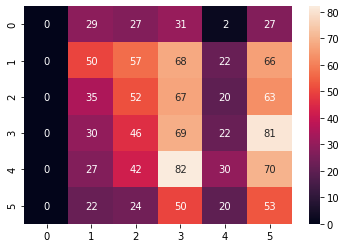

In [14]:
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix
pred_valid_values = [np.argmax(pred_valid[i].detach().numpy(),0) for i in range(pred_valid.shape[0])]
cf_matrix = confusion_matrix(df_valid['target'].values, pred_valid_values)
print(cf_matrix)

import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [13]:
# Save losses
import pickle
with open('fakebert_glove_loss_train.data', 'wb') as filehandle:
    pickle.dump(loss_train, filehandle)
with open('fakebert_glove_loss_test.data', 'wb') as filehandle:
    pickle.dump(loss_test, filehandle)
    
# Save model
torch.save(model.state_dict(), "fakebert_glove_model.pt")